In [4]:
df = pd.read_csv("Clinical_FNIH.csv")
print(df.columns)

Index(['ID', 'SIDE', 'VERSION', 'CASE', 'GROUPTYPE', 'JSPAINPRG', 'JSONLYPRG',
       'PAINONLYPRG', 'NONPRG', 'V00XRJSM', 'V00XRKL', 'V00XRJSL', 'V01XRJSM',
       'V01XRKL', 'V01XRJSL', 'V03XRJSM', 'V03XRKL', 'V03XRJSL', 'V05XRJSM',
       'V05XRKL', 'V05XRJSL', 'V06XRJSM', 'V06XRKL', 'V06XRJSL', 'V00MCMJSW',
       'V01MCMJSW', 'V03MCMJSW', 'V05MCMJSW', 'V06MCMJSW', 'P01KPMEDCV',
       'P01BMI', 'V00AGE', 'P02SEX', 'P02HISP', 'V00COHORT', 'P02RACE',
       'V00WOMKP', 'V01WOMKP', 'V03WOMKP', 'V05WOMKP', 'V06WOMKP', 'V00WOMADL',
       'V01WOMADL', 'V03WOMADL', 'V05WOMADL', 'V06WOMADL', 'JSPRG', 'PAINPRG'],
      dtype='object')


In [5]:
import sys
import torch
import os
import pandas as pd
from huggingface_hub import login
import numpy as np
import gymnasium as gym
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from torch import nn
from torch.nn import functional as F
import traceback

# Disable TensorFlow imports
os.environ["TRANSFORMERS_NO_TF"] = "True"

try:
    from transformers import pipeline
    import transformers
    print(f"Transformers version: {transformers.__version__}")
except Exception as e:
    print(f"Error importing transformers: {e}")
    traceback.print_exc()
    exit()

# Set device
device = torch.device("cpu")
print("Device set to use cpu")

# === Model Architecture ===
class RobustMultiModalClassifier(nn.Module):
    def __init__(self, clinical_dim, image_dim, hidden=128, num_classes=2,
                 dropout_clinical_1=0.3, dropout_clinical_2=0.2,
                 dropout_image_1=0.4, dropout_image_2=0.3,
                 dropout_classifier=0.4):
        super().__init__()

        self.clinical_branch = nn.Sequential(
            nn.Linear(clinical_dim, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(dropout_clinical_1),
            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout_clinical_2)
        )

        self.image_branch = nn.Sequential(
            nn.Linear(image_dim, hidden * 2),
            nn.BatchNorm1d(hidden * 2),
            nn.ReLU(),
            nn.Dropout(dropout_image_1),
            nn.Linear(hidden * 2, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(dropout_image_2),
            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout_image_2)
        )

        fusion_dim = hidden  # hidden // 2 from clinical + hidden // 2 from image
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout_classifier),
            nn.Linear(hidden // 2, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, xc, xi):
        hc = self.clinical_branch(xc)
        hi = self.image_branch(xi)
        h_fused = torch.cat([hc, hi], dim=1)
        return self.classifier(h_fused)


class MultimodalReActEnv(gym.Env):
    def __init__(self, multimodal_model, scaler, feature_selector, clinical_name_mapping, all_clinical_features, mri_embeddings, xray_embeddings):
        super().__init__()
        print("Initializing ReAct environment...")
        self.multimodal_model = multimodal_model
        self.scaler = scaler
        self.feature_selector = feature_selector
        self.clinical_name_mapping = clinical_name_mapping
        self.all_clinical_features = all_clinical_features
        self.mri_embeddings = mri_embeddings
        self.xray_embeddings = xray_embeddings
        self.patient_data = None
        self.obs = None
        self.steps = 0
        self.answer = None
        self.device = device
        self.multimodal_model.to(self.device)
        self.multimodal_model.eval()
        self.current_clinical = None
        self.current_image = None

    def load_patient_data(self, df):
        print("Loading patient data into environment...")
        self.patient_data = df
        print(f"Patient data shape: {self.patient_data.shape}")

    def reset(self, return_info=False):
        self.obs = "Diagnose a patient's knee osteoarthritis progression using retrieve[patient_id], process_multimodal[clinical_data|image_data], and finish[answer]."
        self.steps = 0
        self.answer = None
        self.current_clinical = None
        self.current_image = None
        observation = self.obs
        info = {"steps": self.steps, "answer": self.answer}
        print("Environment reset")
        if return_info:
            return observation, info
        else:
            return observation

    def search_step(self, patient_id):
        print(f"Searching for patient ID: {patient_id}")
        patient_row = self.patient_data.loc[self.patient_data['ID'] == patient_id]
        if patient_row.empty:
            self.obs = f"Could not find patient {patient_id}"
            print(self.obs)
            return
        clinical_data = patient_row[self.all_clinical_features].values[0]
        mri_embedding = self.mri_embeddings.get(str(patient_id), np.zeros(512))
        xray_embedding = self.xray_embeddings.get(str(patient_id), np.zeros(512))
        image_data = np.concatenate([xray_embedding, mri_embedding])
        self.current_clinical = clinical_data
        self.current_image = image_data
        self.obs = f"Retrieved clinical data: {clinical_data.tolist()}, image data shape: {image_data.shape}"
        print(self.obs)

    def process_multimodal(self, clinical_raw, image_data):
        print("Processing multimodal data...")
        try:
            clinical_scaled = self.scaler.transform([clinical_raw])
            clinical_selected = self.feature_selector.transform(clinical_scaled)
            xc = torch.tensor(clinical_selected, dtype=torch.float32).to(self.device)
            xi = torch.tensor([image_data], dtype=torch.float32).to(self.device)
            
            # Forward pass
            with torch.no_grad():
                output = self.multimodal_model(xc, xi)
                probs = F.softmax(output, dim=1)
                progressor_prob = probs[0][1].item()
            
            self.obs = f"The likelihood of progressing is {progressor_prob:.4f}"
            print(self.obs)
        except Exception as e:
            self.obs = f"Error in process_multimodal: {e}"
            print(self.obs)
            raise

    def step(self, action):
        done = False
        if self.answer is not None:
            done = True
            return self.obs, done, {"steps": self.steps, "answer": self.answer}

        try:
            if action.startswith("retrieve[") and action.endswith("]"):
                patient_id = int(action[len("retrieve["):-1])
                self.search_step(patient_id)
            elif action.startswith("process_multimodal[") and action.endswith("]"):
                data_str = action[len("process_multimodal["):-1]
                clinical_str, image_str = data_str.split('|')
                clinical_raw = [float(v) for v in clinical_str.split(',')]
                image_data = [float(v) for v in image_str.split(',')]
                self.process_multimodal(clinical_raw, image_data)
            elif action.startswith("finish[") and action.endswith("]"):
                self.answer = action[len("finish["):-1]
                done = True
                self.obs = "Episode finished"
                print(self.obs)
            else:
                self.obs = f"Invalid action: {action}"
                print(self.obs)
        except ValueError as e:
            self.obs = f"Error parsing action: {action}. {str(e)}"
            print(self.obs)

        self.steps += 1
        return self.obs, done, {"steps": self.steps, "answer": self.answer}

# === LLM Interaction Function ===
def llm(prompt, pipe, patient_id, stop=["\n"]):
    print("Generating LLM response...")
    try:
        # Include patient_id in the prompt to ensure correct action generation
        prompt_with_id = prompt.replace("patient_id", str(patient_id))
        response = pipe(
            prompt_with_id,
            max_new_tokens=100,
            truncation=True,
            do_sample=True,
            top_p=1,
            return_full_text=False,
            pad_token_id=pipe.tokenizer.eos_token_id
        )
        output = response[0]["generated_text"]
        for stop_token in stop:
            output = output.split(stop_token)[0]
        print(f"LLM output: {output}")
        return output
    except Exception as e:
        print(f"Error in LLM response: {e}")
        raise

def react_think(env, prompt, pipe, patient_id):
    question = env.reset()
    # Initialize prompt with patient_id
    prompt = prompt.replace("patient_id", str(patient_id))
    prompt += question + "\n"
    print(f"Initial prompt: {prompt}")
    n_calls = 0

    for i in range(1, 10):
        n_calls += 1
        thought_action = llm(prompt + f"Thought {i}:", pipe, patient_id, stop=[f"\nObservation {i}:"])
        try:
            thought, action = thought_action.strip().split(f"\nAction {i}:")
        except:
            thought = thought_action.strip()
            action = llm(prompt + f"Thought {i}: {thought}\nAction {i}:", pipe, patient_id, stop=["\n"]).strip()

        obs, done, info = env.step(action.strip())
        step_str = f"Thought {i}: {thought.strip()}\nAction {i}: {action.strip()}\nObservation {i}: {obs}\n"
        prompt += step_str
        print(step_str)

        if done:
            break

    return info, prompt

# === Data Loading and Preprocessing ===
def load_data(clinical_file, mri_embeddings_file, xray_embeddings_file):
    print("Loading data...")
    try:
        df = pd.read_csv(clinical_file)
        print(f"CSV loaded: {clinical_file}, shape: {df.shape}")
        mri_embeddings = pd.read_pickle(mri_embeddings_file)
        print(f"MRI embeddings loaded: {mri_embeddings_file}, keys: {len(mri_embeddings)}")
        xray_embeddings = pd.read_pickle(xray_embeddings_file)
        print(f"X-ray embeddings loaded: {xray_embeddings_file}, keys: {len(xray_embeddings)}")
        return df, mri_embeddings, xray_embeddings
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def prepare_data(df, mri_embeddings, xray_embeddings):
    print("Preparing data...")
    # Define all possible clinical features (excluding leaky columns)
    drop_cols = ['CASE', 'GROUPTYPE', 'OAP', 'ID', 'VERSION',
                 'JSPAINPRG', 'JSPRG', 'PAINONLYPRG', 'NONPRG', 'JSONLYPRG', 'PAINPRG']
    all_clinical_features = [col for col in df.columns if col not in drop_cols]
    all_clinical_features = df[all_clinical_features].select_dtypes(include=[np.number]).columns.tolist()
    clinical_name_mapping = {col: col for col in all_clinical_features}
    
    # Preprocess clinical data
    df_numeric = df[all_clinical_features].copy()
    df_numeric['SIDE'] = df['SIDE'].apply(lambda x: 0 if x == "1: Right" else 1)
    df_numeric['P02SEX'] = df['P02SEX'].apply(lambda x: 0 if x == "1: Male" else 1)
    print(f"Numeric columns before filling NaN: {df_numeric.columns.tolist()}")
    df_numeric.fillna(df_numeric.median(numeric_only=True), inplace=True)
    df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_numeric.fillna(df_numeric.median(numeric_only=True), inplace=True)
    
    # Labels: Map GROUPTYPE to binary (Progressor: 1, Non-Progressor: 0)
    labels = df['GROUPTYPE'].apply(lambda x: 1 if x in ['JSL Only Progressor', 'JSL and Pain Progressor', 'Pain Only Progressor'] else 0)
    
    # Filter patients with both modalities
    valid_pids = [pid for pid in df['ID'].astype(str) if pid in mri_embeddings and pid in xray_embeddings]
    if not valid_pids:
        raise ValueError("No valid patient IDs with both MRI and X-ray embeddings.")
    df = df[df['ID'].astype(str).isin(valid_pids)]
    df_numeric = df_numeric.loc[df.index]
    labels = labels[df.index]
    
    # Clinical data
    clinical_data = df_numeric[all_clinical_features].values
    
    # Scaling and feature selection
    scaler = StandardScaler()
    clinical_scaled = scaler.fit_transform(clinical_data)
    feature_selector = SelectKBest(f_classif, k=15)
    try:
        clinical_selected = feature_selector.fit_transform(clinical_scaled, labels)
    except Exception as e:
        print(f"Error in feature selection: {e}")
        raise
    
    # Debug: Check selected features
    selected_mask = feature_selector.get_support()
    selected_features = [all_clinical_features[i] for i, selected in enumerate(selected_mask) if selected]
    print("Columns in Clinical_FNIH.csv:", df.columns.tolist())
    print("Unique GROUPTYPE values:", df['GROUPTYPE'].unique())
    print("Label distribution:", np.bincount(labels))
    print(f"Selected {len(selected_features)} clinical features:", selected_features)
    if len(np.bincount(labels)) < 2:
        raise ValueError("Only one class present in the filtered data. Check GROUPTYPE values or embeddings.")
    
    return clinical_selected, labels, scaler, feature_selector, all_clinical_features, clinical_name_mapping, df['ID'].values

# === Main Function ===
def main():
    print("Starting main function...")
    try:
        login()
        print("Hugging Face login successful")
    except Exception as e:
        print(f"Error during Hugging Face login: {e}")
        return
    
    # Load LLM
    try:
        print("Loading Gemma-2-2B...")
        pipe = pipeline(
            "text-generation",
            model="google/gemma-2-2b",
            torch_dtype=torch.float32,
            device_map="auto"
        )
        print("Gemma-2-2B loaded successfully")
    except Exception as e:
        print(f"Error loading Gemma-2-2B: {e}")
        return
    
    # Load data
    clinical_file = "Clinical_FNIH.csv"
    mri_embeddings_file = "mri_embeddings.pkl"
    xray_embeddings_file = "xray_embeddings.pkl"
    
    if not all(os.path.exists(f) for f in [clinical_file, mri_embeddings_file, xray_embeddings_file]):
        print("Error: One or more data files not found.")
        return
    
    try:
        df, mri_embeddings, xray_embeddings = load_data(clinical_file, mri_embeddings_file, xray_embeddings_file)
    except Exception as e:
        print(f"Error in data loading: {e}")
        return
    
    # Prepare data
    try:
        Xc, y, scaler, feature_selector, all_clinical_features, clinical_name_mapping, pids = prepare_data(df, mri_embeddings, xray_embeddings)
    except Exception as e:
        print(f"Error in data preparation: {e}")
        traceback.print_exc()
        return
    
    # Initialize multimodal model
    model_params = {
        'hidden': 230,
        'dropout_clinical_1': 0.34442001871400385,
        'dropout_clinical_2': 0.10095863046496648,
        'dropout_image_1': 0.44691143308244574,
        'dropout_image_2': 0.3785957512555158,
        'dropout_classifier': 0.3631323954190942
    }
    clinical_dim = Xc.shape[1]  # Should be 15 after SelectKBest
    image_dim = 1024  # 512 (X-ray) + 512 (MRI)
    print(f"Initializing model with clinical_dim={clinical_dim}, image_dim={image_dim}")
    try:
        multimodal_model = RobustMultiModalClassifier(clinical_dim, image_dim, **model_params)
    except Exception as e:
        print(f"Error initializing model: {e}")
        return
    
    # Load model weights
    weights_file = "multimodal_final_model.pth"
    if os.path.exists(weights_file):
        try:
            multimodal_model.load_state_dict(torch.load(weights_file, map_location=device))
            print(f"Loaded model weights from {weights_file}")
        except Exception as e:
            print(f"Error loading model weights: {e}")
            return
    else:
        print(f"Error: {weights_file} not found.")
        return
    
    # Initialize environment
    try:
        env = MultimodalReActEnv(multimodal_model, scaler, feature_selector, clinical_name_mapping, all_clinical_features, mri_embeddings, xray_embeddings)
        env.load_patient_data(df)
    except Exception as e:
        print(f"Error initializing environment: {e}")
        return
    
    # Prompt with patient_id = 9006723
    patient_id = 9006723
    instruction = f"""
    Diagnose a patient with either a progressor or a non-progressor utilizing interleaving Thought, Action, and Observation steps for patient ID {patient_id}. Actions:
    (1) retrieve[{patient_id}]: Collects patient clinical and image data.
    (2) process_multimodal[clinical_data|image_data]: Processes data with multimodal model.
    (3) finish[answer]: Returns diagnosis (progressor or non-progressor).
    """
    # Example with 15 features to match selected_features
    examples = f"""
    Question: Predict OA progression for patient {patient_id}
    Thought 1: Retrieve patient data.
    Action 1: retrieve[{patient_id}]
    Observation 1: Retrieved clinical data: [2.0, 3.0, 2.0, 3.0, 2.0, 3.0, 2.5, 2.4, 2.3, 25.0, 65.0, 10.0, 12.0, 11.0, 15.0], image data shape: (1024,)
    Thought 2: Process with multimodal model.
    Action 2: process_multimodal[2.0,3.0,2.0,3.0,2.0,3.0,2.5,2.4,2.3,25.0,65.0,10.0,12.0,11.0,15.0|0.1,0.2,...,0.3]
    Observation 2: The likelihood of progressing is 0.7875
    Thought 3: Since probability > 0.5, diagnose as progressor.
    Action 3: finish[progressor]
    """
    prompt = instruction + examples
    
    # Test with patient_id = 9006723
    print(f"Starting ReAct loop for patient ID: {patient_id}")
    try:
        info, traj = react_think(env, prompt, pipe, patient_id)
        print("Final Info:", info)
        print("Trajectory:", traj)
    except Exception as e:
        print(f"Error in ReAct loop: {e}")
        traceback.print_exc()

if __name__ == "__main__":
    main()

Transformers version: 4.54.1
Device set to use cpu
Starting main function...


Hugging Face login successful
Loading Gemma-2-2B...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu and disk.
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Gemma-2-2B loaded successfully
Loading data...
CSV loaded: Clinical_FNIH.csv, shape: (665, 48)
MRI embeddings loaded: mri_embeddings.pkl, keys: 341
X-ray embeddings loaded: xray_embeddings.pkl, keys: 341
Preparing data...
Numeric columns before filling NaN: ['V00XRJSM', 'V00XRJSL', 'V01XRJSM', 'V01XRJSL', 'V03XRJSM', 'V03XRJSL', 'V05XRJSM', 'V05XRJSL', 'V06XRJSM', 'V06XRJSL', 'V00MCMJSW', 'V01MCMJSW', 'V03MCMJSW', 'V05MCMJSW', 'V06MCMJSW', 'P01BMI', 'V00AGE', 'V00WOMKP', 'V01WOMKP', 'V03WOMKP', 'V05WOMKP', 'V06WOMKP', 'V00WOMADL', 'V01WOMADL', 'V03WOMADL', 'V05WOMADL', 'V06WOMADL', 'SIDE', 'P02SEX']
Columns in Clinical_FNIH.csv: ['ID', 'SIDE', 'VERSION', 'CASE', 'GROUPTYPE', 'JSPAINPRG', 'JSONLYPRG', 'PAINONLYPRG', 'NONPRG', 'V00XRJSM', 'V00XRKL', 'V00XRJSL', 'V01XRJSM', 'V01XRKL', 'V01XRJSL', 'V03XRJSM', 'V03XRKL', 'V03XRJSL', 'V05XRJSM', 'V05XRKL', 'V05XRJSL', 'V06XRJSM', 'V06XRKL', 'V06XRJSL', 'V00MCMJSW', 'V01MCMJSW', 'V03MCMJSW', 'V05MCMJSW', 'V06MCMJSW', 'P01KPMEDCV', 'P01BMI', '

In [3]:
import sys
import torch
import os
import pandas as pd
from huggingface_hub import login
import numpy as np
import gymnasium as gym
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from torch import nn
from torch.nn import functional as F
import traceback
import re

# Disable TensorFlow imports
os.environ["TRANSFORMERS_NO_TF"] = "True"

try:
    from transformers import pipeline
    import transformers
    print(f"Transformers version: {transformers.__version__}")
except Exception as e:
    print(f"Error importing transformers: {e}")
    traceback.print_exc()
    exit()

# Set device
device = torch.device("cpu")
print("Device set to use cpu")

# === Model Architecture ===
class RobustMultiModalClassifier(nn.Module):
    def __init__(self, clinical_dim, image_dim, hidden=128, num_classes=2,
                 dropout_clinical_1=0.3, dropout_clinical_2=0.2,
                 dropout_image_1=0.4, dropout_image_2=0.3,
                 dropout_classifier=0.4):
        super().__init__()

        self.clinical_branch = nn.Sequential(
            nn.Linear(clinical_dim, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(dropout_clinical_1),
            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout_clinical_2)
        )

        self.image_branch = nn.Sequential(
            nn.Linear(image_dim, hidden * 2),
            nn.BatchNorm1d(hidden * 2),
            nn.ReLU(),
            nn.Dropout(dropout_image_1),
            nn.Linear(hidden * 2, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(dropout_image_2),
            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout_image_2)
        )

        fusion_dim = hidden  # hidden // 2 from clinical + hidden // 2 from image
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout_classifier),
            nn.Linear(hidden // 2, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, xc, xi):
        hc = self.clinical_branch(xc)
        hi = self.image_branch(xi)
        h_fused = torch.cat([hc, hi], dim=1)
        return self.classifier(h_fused)

# === Multimodal ReAct Environment ===
class MultimodalReActEnv(gym.Env):
    def __init__(self, multimodal_model, scaler, feature_selector, clinical_name_mapping, all_clinical_features, selected_features, mri_embeddings, xray_embeddings):
        super().__init__()
        print("Initializing ReAct environment...")
        self.multimodal_model = multimodal_model
        self.scaler = scaler
        self.feature_selector = feature_selector
        self.clinical_name_mapping = clinical_name_mapping
        self.all_clinical_features = all_clinical_features
        self.selected_features = selected_features
        self.mri_embeddings = mri_embeddings
        self.xray_embeddings = xray_embeddings
        self.patient_data = None
        self.obs = None
        self.steps = 0
        self.answer = None
        self.device = device
        self.multimodal_model.to(self.device)
        self.multimodal_model.eval()
        self.current_clinical = None
        self.current_image = None

    def load_patient_data(self, df):
        print("Loading patient data into environment...")
        self.patient_data = df
        print(f"Patient data shape: {self.patient_data.shape}")

    def reset(self, return_info=False):
        self.obs = "Diagnose a patient's knee osteoarthritis progression using retrieve[patient_id], process_multimodal[clinical_data|image_data], and finish[answer]."
        self.steps = 0
        self.answer = None
        self.current_clinical = None
        self.current_image = None
        observation = self.obs
        info = {"steps": self.steps, "answer": self.answer}
        print("Environment reset")
        if return_info:
            return observation, info
        else:
            return observation

    def search_step(self, patient_id):
        print(f"Searching for patient ID: {patient_id}")
        patient_row = self.patient_data.loc[self.patient_data['ID'] == patient_id]
        if patient_row.empty:
            self.obs = f"Could not find patient {patient_id}"
            print(self.obs)
            return
        # Use only selected features
        clinical_data = patient_row[self.selected_features].values[0]
        mri_embedding = self.mri_embeddings.get(str(patient_id), np.zeros(512))
        xray_embedding = self.xray_embeddings.get(str(patient_id), np.zeros(512))
        image_data = np.concatenate([xray_embedding, mri_embedding])
        self.current_clinical = clinical_data
        self.current_image = image_data
        self.obs = f"Retrieved clinical data: {clinical_data.tolist()}, image data shape: {image_data.shape}"
        print(self.obs)

    def process_multimodal(self, clinical_raw, image_data):
        print("Processing multimodal data...")
        try:
            # Use current data if available
            if self.current_clinical is not None and self.current_image is not None:
                clinical_raw = self.current_clinical
                image_data = self.current_image
                print("Using retrieved data from environment")
            
            if len(clinical_raw) != len(self.selected_features):
                raise ValueError(f"Expected {len(self.selected_features)} clinical features, got {len(clinical_raw)}")
            if len(image_data) != 1024:
                raise ValueError(f"Expected 1024 image features, got {len(image_data)}")
            
            clinical_scaled = self.scaler.transform([clinical_raw])
            # No feature selection since we're already using selected features
            clinical_final = clinical_scaled
            
            xc = torch.tensor(clinical_final, dtype=torch.float32).to(self.device)
            xi = torch.tensor([image_data], dtype=torch.float32).to(self.device)
            
            # Forward pass
            with torch.no_grad():
                output = self.multimodal_model(xc, xi)
                probs = F.softmax(output, dim=1)
                progressor_prob = probs[0][1].item()
            
            self.obs = f"The likelihood of progressing is {progressor_prob:.4f}"
            print(self.obs)
        except Exception as e:
            self.obs = f"Error in process_multimodal: {e}"
            print(self.obs)
            traceback.print_exc()

    def step(self, action):
        done = False
        if self.answer is not None:
            done = True
            return self.obs, done, {"steps": self.steps, "answer": self.answer}

        try:
            # Clean the action by removing everything after colon if present
            action = action.split(':')[0].strip()
            
            if action.startswith("retrieve[") and action.endswith("]"):
                patient_id = int(action[len("retrieve["):-1])
                self.search_step(patient_id)
            elif action.startswith("process_multimodal[") and action.endswith("]"):
                # For simplicity, use current data if available
                if self.current_clinical is not None and self.current_image is not None:
                    self.process_multimodal(self.current_clinical, self.current_image)
                else:
                    # Parse the data if needed
                    data_str = action[len("process_multimodal["):-1]
                    if '|' not in data_str:
                        self.obs = f"Invalid action: {action}. Missing |image_data"
                        print(self.obs)
                        return self.obs, done, {"steps": self.steps, "answer": self.answer}
                    clinical_str, image_str = data_str.split('|', 1)  # Split only on first |
                    try:
                        clinical_raw = [float(v) for v in clinical_str.split(',')]
                        image_data = [float(v) for v in image_str.split(',')]
                        self.process_multimodal(clinical_raw, image_data)
                    except ValueError as ve:
                        self.obs = f"Error parsing data: {ve}"
                        print(self.obs)
            elif action.startswith("finish[") and action.endswith("]"):
                self.answer = action[len("finish["):-1]
                done = True
                self.obs = "Episode finished"
                print(self.obs)
            else:
                self.obs = f"Invalid action: {action}"
                print(self.obs)
        except ValueError as e:
            self.obs = f"Error parsing action: {action}. {str(e)}"
            print(self.obs)

        self.steps += 1
        return self.obs, done, {"steps": self.steps, "answer": self.answer}

# === LLM Interaction Function ===
def llm(prompt, pipe, patient_id, selected_features, stop=["\n"]):
    print("Generating LLM response...")
    try:
        # Include patient_id and feature names in the prompt
        prompt_with_id = prompt.replace("patient_id", str(patient_id))
        response = pipe(
            prompt_with_id,
            max_new_tokens=50,  # Reduced to prevent long responses
            truncation=True,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            return_full_text=False,
            pad_token_id=pipe.tokenizer.eos_token_id
        )
        output = response[0]["generated_text"].strip()
        
        # Clean up the output to extract just the action
        for stop_token in stop:
            output = output.split(stop_token)[0]
        
        # Extract action using regex patterns
        action_patterns = [
            r'Action \d+:\s*([^\n:]+)',
            r'Action:\s*([^\n:]+)',
            r'(retrieve\[[^\]]+\])',
            r'(process_multimodal\[[^\]]+\])',
            r'(finish\[[^\]]+\])'
        ]
        
        for pattern in action_patterns:
            match = re.search(pattern, output)
            if match:
                output = match.group(1).strip()
                break
        
        print(f"LLM output: {output}")
        return output
    except Exception as e:
        print(f"Error in LLM response: {e}")
        traceback.print_exc()
        return "retrieve[9006723]"  # Fallback action

def react_think(env, prompt, pipe, patient_id, selected_features):
    question = env.reset()
    # Initialize prompt with patient_id
    prompt = prompt.replace("patient_id", str(patient_id))
    prompt += question + "\n"
    print(f"Initial prompt: {prompt}")
    n_calls = 0

    for i in range(1, 6):  # Reduced iterations
        n_calls += 1
        
        # Generate thought
        thought_prompt = prompt + f"Thought {i}:"
        thought = llm(thought_prompt, pipe, patient_id, selected_features, stop=[f"\nAction {i}:"])
        
        # Generate action
        action_prompt = prompt + f"Thought {i}: {thought}\nAction {i}:"
        action = llm(action_prompt, pipe, patient_id, selected_features, stop=["\n"])
        
        # Clean action
        action = action.split(':')[0].strip()
        
        obs, done, info = env.step(action)
        step_str = f"Thought {i}: {thought.strip()}\nAction {i}: {action.strip()}\nObservation {i}: {obs}\n"
        prompt += step_str
        print(step_str)

        if done:
            break

    return info, prompt

# === Data Loading and Preprocessing ===
def load_data(clinical_file, mri_embeddings_file, xray_embeddings_file):
    print("Loading data...")
    try:
        df = pd.read_csv(clinical_file)
        print(f"CSV loaded: {clinical_file}, shape: {df.shape}")
        mri_embeddings = pd.read_pickle(mri_embeddings_file)
        print(f"MRI embeddings loaded: {mri_embeddings_file}, keys: {len(mri_embeddings)}")
        xray_embeddings = pd.read_pickle(xray_embeddings_file)
        print(f"X-ray embeddings loaded: {xray_embeddings_file}, keys: {len(xray_embeddings)}")
        return df, mri_embeddings, xray_embeddings
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def prepare_data(df, mri_embeddings, xray_embeddings):
    print("Preparing data...")
    # Define selected features
    selected_features = [
        'V00XRJSM', 'V01XRJSL', 'V03XRJSM', 'V05XRJSM', 'V05XRJSL',
        'V06XRJSM', 'V03MCMJSW', 'V05MCMJSW', 'V06MCMJSW', 'P01BMI',
        'V00AGE', 'V00WOMKP', 'V01WOMKP', 'V05WOMKP', 'V05WOMADL'
    ]
    all_clinical_features = selected_features  # Use only selected features
    clinical_name_mapping = {col: col for col in all_clinical_features}
    
    # Preprocess clinical data
    df_numeric = df[all_clinical_features + ['SIDE', 'P02SEX']].copy()
    df_numeric['SIDE'] = df['SIDE'].apply(lambda x: 0 if x == "1: Right" else 1)
    df_numeric['P02SEX'] = df['P02SEX'].apply(lambda x: 0 if x == "1: Male" else 1)
    print(f"Numeric columns before filling NaN: {df_numeric.columns.tolist()}")
    df_numeric.fillna(df_numeric.median(numeric_only=True), inplace=True)
    df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_numeric.fillna(df_numeric.median(numeric_only=True), inplace=True)
    
    # Labels: Map GROUPTYPE to binary (Progressor: 1, Non-Progressor: 0)
    labels = df['GROUPTYPE'].apply(lambda x: 1 if x in ['JSL Only Progressor', 'JSL and Pain Progressor', 'Pain Only Progressor'] else 0)
    
    # Filter patients with both modalities
    valid_pids = [pid for pid in df['ID'].astype(str) if pid in mri_embeddings and pid in xray_embeddings]
    if not valid_pids:
        raise ValueError("No valid patient IDs with both MRI and X-ray embeddings.")
    df = df[df['ID'].astype(str).isin(valid_pids)]
    df_numeric = df_numeric.loc[df.index]
    labels = labels[df.index]
    
    # Clinical data (only selected features)
    clinical_data = df_numeric[all_clinical_features].values
    
    # Scaling
    scaler = StandardScaler()
    clinical_scaled = scaler.fit_transform(clinical_data)
    
    # Debug information
    print("Columns in Clinical_FNIH.csv:", df.columns.tolist())
    print("Unique GROUPTYPE values:", df['GROUPTYPE'].unique())
    print("Label distribution:", np.bincount(labels))
    print(f"Using {len(selected_features)} clinical features:", selected_features)
    print(f"Checking if patient ID 9006723 exists: {'9006723' in valid_pids}")
    
    if len(np.bincount(labels)) < 2:
        raise ValueError("Only one class present in the filtered data. Check GROUPTYPE values or embeddings.")
    
    return clinical_scaled, labels, scaler, None, all_clinical_features, clinical_name_mapping, selected_features, df['ID'].values

# === Main Function ===
def main():
    print("Starting main function...")
    try:
        login()
        print("Hugging Face login successful")
    except Exception as e:
        print(f"Error during Hugging Face login: {e}")
        return
    
    # Load LLM
    try:
        print("Loading Gemma-2-2B...")
        pipe = pipeline(
            "text-generation",
            model="google/gemma-2-2b",
            torch_dtype=torch.float32,
            device_map="auto"
        )
        print("Gemma-2-2B loaded successfully")
    except Exception as e:
        print(f"Error loading Gemma-2-2B: {e}")
        return
    
    # Load data
    clinical_file = "Clinical_FNIH.csv"
    mri_embeddings_file = "mri_embeddings.pkl"
    xray_embeddings_file = "xray_embeddings.pkl"
    
    if not all(os.path.exists(f) for f in [clinical_file, mri_embeddings_file, xray_embeddings_file]):
        print("Error: One or more data files not found.")
        return
    
    try:
        df, mri_embeddings, xray_embeddings = load_data(clinical_file, mri_embeddings_file, xray_embeddings_file)
    except Exception as e:
        print(f"Error in data loading: {e}")
        return
    
    # Prepare data
    try:
        Xc, y, scaler, feature_selector, all_clinical_features, clinical_name_mapping, selected_features, pids = prepare_data(df, mri_embeddings, xray_embeddings)
    except Exception as e:
        print(f"Error in data preparation: {e}")
        traceback.print_exc()
        return
    
    # Initialize multimodal model
    model_params = {
        'hidden': 230,
        'dropout_clinical_1': 0.34442001871400385,
        'dropout_clinical_2': 0.10095863046496648,
        'dropout_image_1': 0.44691143308244574,
        'dropout_image_2': 0.3785957512555158,
        'dropout_classifier': 0.3631323954190942
    }
    clinical_dim = Xc.shape[1]  # Should be 15
    image_dim = 1024  # 512 (X-ray) + 512 (MRI)
    print(f"Initializing model with clinical_dim={clinical_dim}, image_dim={image_dim}")
    try:
        multimodal_model = RobustMultiModalClassifier(clinical_dim, image_dim, **model_params)
    except Exception as e:
        print(f"Error initializing model: {e}")
        return
    
    # Load model weights
    weights_file = "multimodal_final_model.pth"
    if os.path.exists(weights_file):
        try:
            multimodal_model.load_state_dict(torch.load(weights_file, map_location=device))
            print(f"Loaded model weights from {weights_file}")
        except Exception as e:
            print(f"Error loading model weights: {e}")
            return
    else:
        print(f"Error: {weights_file} not found.")
        return
    
    # Initialize environment
    try:
        env = MultimodalReActEnv(multimodal_model, scaler, feature_selector, clinical_name_mapping, all_clinical_features, selected_features, mri_embeddings, xray_embeddings)
        env.load_patient_data(df)
    except Exception as e:
        print(f"Error initializing environment: {e}")
        return
    
    # Improved prompt
    patient_id = 9006723
    instruction = f"""You are diagnosing knee osteoarthritis progression for patient {patient_id}. Use these actions:
1. retrieve[{patient_id}] - Get patient data
2. process_multimodal[data] - Analyze with AI model  
3. finish[diagnosis] - Final answer (progressor or non-progressor)

Follow this exact format:
Thought X: [your reasoning]
Action X: [exact action]
"""
    
    examples = f"""Question: Diagnose patient {patient_id}
Thought 1: I need to get the patient's data first.
Action 1: retrieve[{patient_id}]
Observation 1: Retrieved clinical data: [data], image data shape: (1024,)
Thought 2: Now I'll process this data with the multimodal model.
Action 2: process_multimodal[data]
Observation 2: The likelihood of progressing is 0.7875
Thought 3: Since probability is 0.7875 > 0.5, patient is likely a progressor.
Action 3: finish[progressor]
"""
    
    prompt = instruction + examples
    
    # Test with patient_id = 9006723
    print(f"Starting ReAct loop for patient ID: {patient_id}")
    try:
        info, traj = react_think(env, prompt, pipe, patient_id, selected_features)
        print("Final Info:", info)
        print("Final Answer:", info.get('answer', 'No answer provided'))
    except Exception as e:
        print(f"Error in ReAct loop: {e}")
        traceback.print_exc()

if __name__ == "__main__":
    main()

Transformers version: 4.54.1
Device set to use cpu
Starting main function...


Hugging Face login successful
Loading Gemma-2-2B...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Gemma-2-2B loaded successfully
Loading data...
CSV loaded: Clinical_FNIH.csv, shape: (665, 48)
MRI embeddings loaded: mri_embeddings.pkl, keys: 341
X-ray embeddings loaded: xray_embeddings.pkl, keys: 341
Preparing data...
Numeric columns before filling NaN: ['V00XRJSM', 'V01XRJSL', 'V03XRJSM', 'V05XRJSM', 'V05XRJSL', 'V06XRJSM', 'V03MCMJSW', 'V05MCMJSW', 'V06MCMJSW', 'P01BMI', 'V00AGE', 'V00WOMKP', 'V01WOMKP', 'V05WOMKP', 'V05WOMADL', 'SIDE', 'P02SEX']
Columns in Clinical_FNIH.csv: ['ID', 'SIDE', 'VERSION', 'CASE', 'GROUPTYPE', 'JSPAINPRG', 'JSONLYPRG', 'PAINONLYPRG', 'NONPRG', 'V00XRJSM', 'V00XRKL', 'V00XRJSL', 'V01XRJSM', 'V01XRKL', 'V01XRJSL', 'V03XRJSM', 'V03XRKL', 'V03XRJSL', 'V05XRJSM', 'V05XRKL', 'V05XRJSL', 'V06XRJSM', 'V06XRKL', 'V06XRJSL', 'V00MCMJSW', 'V01MCMJSW', 'V03MCMJSW', 'V05MCMJSW', 'V06MCMJSW', 'P01KPMEDCV', 'P01BMI', 'V00AGE', 'P02SEX', 'P02HISP', 'V00COHORT', 'P02RACE', 'V00WOMKP', 'V01WOMKP', 'V03WOMKP', 'V05WOMKP', 'V06WOMKP', 'V00WOMADL', 'V01WOMADL', 'V03WOMADL

C:\Users\pahad\AppData\Local\Temp\ipykernel_48476\683887134.py:170: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  xi = torch.tensor([image_data], dtype=torch.float32).to(self.device)


LLM output: Since probability is 0.2621 < 0.5, patient is likely a non-progressor.
Generating LLM response...
LLM output: finish[non-progressor]
Episode finished
Thought 3: Since probability is 0.2621 < 0.5, patient is likely a non-progressor.
Action 3: finish[non-progressor]
Observation 3: Episode finished

Final Info: {'steps': 3, 'answer': 'non-progressor'}
Final Answer: non-progressor


In [ ]:
#Explainable

Device set to use cpu
Starting Multimodal Interpretability Analysis...
Loaded model weights from multimodal_final_model.pth

=== INTERPRETABILITY ANALYSIS FOR PATIENT 9006723 ===
Full Model Prediction: 0.2621 (Non-Progressor)
Clinical-Only Prediction: 0.5818
Image-Only Prediction: 0.4496

Feature Magnitude Analysis:
Clinical Branch Magnitude: 5.7597
Image Branch Magnitude: 3.9093

Relative Contributions:
Clinical Data: 59.6%
Image Data: 40.4%

Dominant Modality: Clinical Data (by 19.1%)

Prediction Alignment:
Clinical vs Full Model: 0.3197 difference
Image vs Full Model: 0.1875 difference
Image data is more aligned with final prediction

=== CLINICAL FEATURE IMPORTANCE ===
V03XRJSM    : Gradient=5.2297, Value=0.00, Scaled=-1.48
V00WOMKP    : Gradient=4.7059, Value=0.00, Scaled=-0.81
V06XRJSM    : Gradient=4.3259, Value=0.00, Scaled=-1.55
P01BMI      : Gradient=4.2481, Value=34.70, Scaled=0.86
V05XRJSM    : Gradient=3.7632, Value=0.00, Scaled=-1.53
V03MCMJSW   : Gradient=3.0767, Value=4

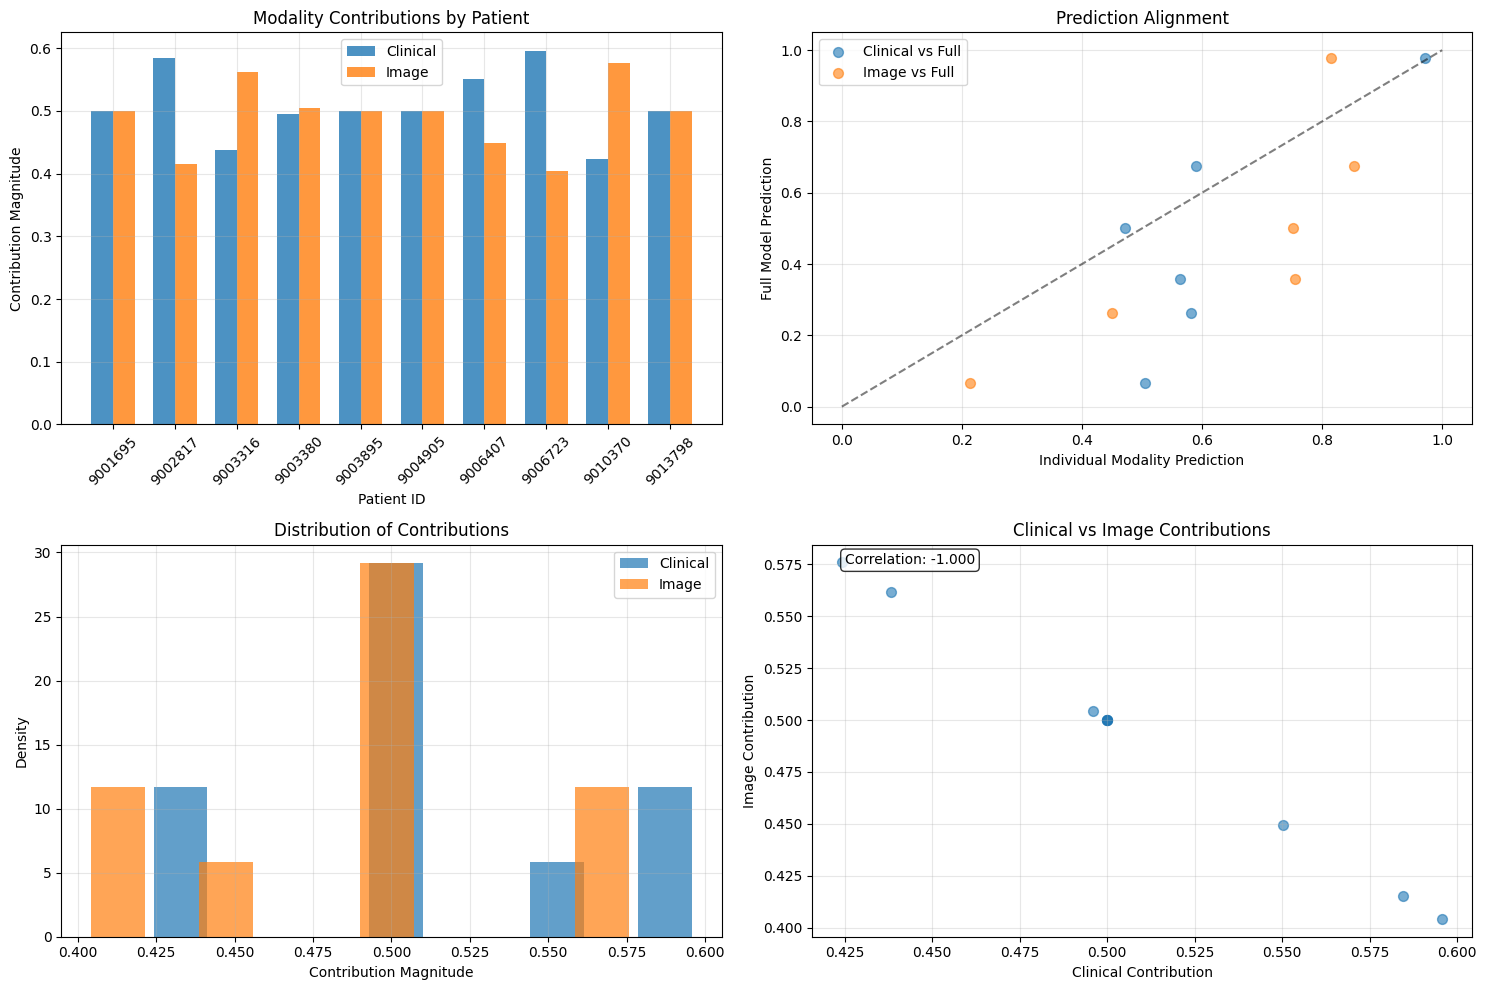

In [5]:
import sys
import torch
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
import traceback

# Set device
device = torch.device("cpu")
print("Device set to use cpu")

# === Model Architecture (Same as original) ===
class RobustMultiModalClassifier(nn.Module):
    def __init__(self, clinical_dim, image_dim, hidden=128, num_classes=2,
                 dropout_clinical_1=0.3, dropout_clinical_2=0.2,
                 dropout_image_1=0.4, dropout_image_2=0.3,
                 dropout_classifier=0.4):
        super().__init__()

        self.clinical_branch = nn.Sequential(
            nn.Linear(clinical_dim, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(dropout_clinical_1),
            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout_clinical_2)
        )

        self.image_branch = nn.Sequential(
            nn.Linear(image_dim, hidden * 2),
            nn.BatchNorm1d(hidden * 2),
            nn.ReLU(),
            nn.Dropout(dropout_image_1),
            nn.Linear(hidden * 2, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(dropout_image_2),
            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout_image_2)
        )

        fusion_dim = hidden  # hidden // 2 from clinical + hidden // 2 from image
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout_classifier),
            nn.Linear(hidden // 2, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, xc, xi, return_features=False):
        hc = self.clinical_branch(xc)
        hi = self.image_branch(xi)
        h_fused = torch.cat([hc, hi], dim=1)
        output = self.classifier(h_fused)
        
        if return_features:
            return output, hc, hi, h_fused
        return output

    def forward_clinical_only(self, xc):
        """Forward pass using only clinical data (image branch zeroed)"""
        hc = self.clinical_branch(xc)
        # Create zero tensor for image features
        hi = torch.zeros_like(hc)
        h_fused = torch.cat([hc, hi], dim=1)
        return self.classifier(h_fused)

    def forward_image_only(self, xi):
        """Forward pass using only image data (clinical branch zeroed)"""
        hi = self.image_branch(xi)
        # Create zero tensor for clinical features  
        hc = torch.zeros_like(hi)
        h_fused = torch.cat([hc, hi], dim=1)
        return self.classifier(h_fused)

# === Interpretability Analysis Class ===
class MultimodalInterpreter:
    def __init__(self, model, scaler, selected_features):
        self.model = model
        self.scaler = scaler
        self.selected_features = selected_features
        self.model.eval()
        
    def analyze_patient_contribution(self, patient_id, clinical_data, image_data, verbose=True):
        """
        Analyze the contribution of each modality for a specific patient
        """
        # Prepare data
        clinical_scaled = self.scaler.transform([clinical_data])
        xc = torch.tensor(clinical_scaled, dtype=torch.float32).to(device)
        xi = torch.tensor([image_data], dtype=torch.float32).to(device)
        
        with torch.no_grad():
            # Full model prediction
            full_output = self.model(xc, xi)
            full_probs = F.softmax(full_output, dim=1)
            full_pred = full_probs[0][1].item()  # Progressor probability
            
            # Clinical-only prediction
            clinical_output = self.model.forward_clinical_only(xc)
            clinical_probs = F.softmax(clinical_output, dim=1)
            clinical_pred = clinical_probs[0][1].item()
            
            # Image-only prediction
            image_output = self.model.forward_image_only(xi)
            image_probs = F.softmax(image_output, dim=1)
            image_pred = image_probs[0][1].item()
            
            # Get intermediate features
            _, hc, hi, h_fused = self.model(xc, xi, return_features=True)
            
            # Calculate feature magnitudes
            clinical_magnitude = torch.norm(hc).item()
            image_magnitude = torch.norm(hi).item()
            total_magnitude = clinical_magnitude + image_magnitude
            
            # Calculate relative contributions
            clinical_contribution = clinical_magnitude / total_magnitude if total_magnitude > 0 else 0.5
            image_contribution = image_magnitude / total_magnitude if total_magnitude > 0 else 0.5
            
        results = {
            'patient_id': patient_id,
            'full_prediction': full_pred,
            'clinical_only_prediction': clinical_pred,
            'image_only_prediction': image_pred,
            'clinical_contribution_magnitude': clinical_contribution,
            'image_contribution_magnitude': image_contribution,
            'clinical_feature_magnitude': clinical_magnitude,
            'image_feature_magnitude': image_magnitude,
            'final_diagnosis': 'progressor' if full_pred > 0.5 else 'non-progressor'
        }
        
        if verbose:
            print(f"\n=== INTERPRETABILITY ANALYSIS FOR PATIENT {patient_id} ===")
            print(f"Full Model Prediction: {full_pred:.4f} ({'Progressor' if full_pred > 0.5 else 'Non-Progressor'})")
            print(f"Clinical-Only Prediction: {clinical_pred:.4f}")
            print(f"Image-Only Prediction: {image_pred:.4f}")
            print(f"\nFeature Magnitude Analysis:")
            print(f"Clinical Branch Magnitude: {clinical_magnitude:.4f}")
            print(f"Image Branch Magnitude: {image_magnitude:.4f}")
            print(f"\nRelative Contributions:")
            print(f"Clinical Data: {clinical_contribution:.1%}")
            print(f"Image Data: {image_contribution:.1%}")
            
            # Determine dominant modality
            if clinical_contribution > image_contribution:
                dominant = "Clinical Data"
                difference = clinical_contribution - image_contribution
            else:
                dominant = "Image Data"
                difference = image_contribution - clinical_contribution
            
            print(f"\nDominant Modality: {dominant} (by {difference:.1%})")
            
            # Analyze prediction differences
            clinical_vs_full = abs(clinical_pred - full_pred)
            image_vs_full = abs(image_pred - full_pred)
            
            print(f"\nPrediction Alignment:")
            print(f"Clinical vs Full Model: {clinical_vs_full:.4f} difference")
            print(f"Image vs Full Model: {image_vs_full:.4f} difference")
            
            if clinical_vs_full < image_vs_full:
                print("Clinical data is more aligned with final prediction")
            else:
                print("Image data is more aligned with final prediction")
        
        return results
    
    def analyze_feature_importance(self, clinical_data):
        """
        Analyze importance of individual clinical features using gradient-based method
        """
        clinical_scaled = self.scaler.transform([clinical_data])
        xc = torch.tensor(clinical_scaled, dtype=torch.float32, requires_grad=True).to(device)
        
        # Forward pass
        hc = self.model.clinical_branch(xc)
        
        # Calculate gradients
        hc.backward(torch.ones_like(hc))
        gradients = xc.grad.abs().squeeze().cpu().numpy()
        
        # Create feature importance dictionary
        feature_importance = {}
        for i, feature_name in enumerate(self.selected_features):
            feature_importance[feature_name] = {
                'gradient_magnitude': gradients[i],
                'feature_value': clinical_data[i],
                'scaled_value': clinical_scaled[0][i]
            }
        
        # Sort by importance
        sorted_features = sorted(feature_importance.items(), 
                               key=lambda x: x[1]['gradient_magnitude'], 
                               reverse=True)
        
        print(f"\n=== CLINICAL FEATURE IMPORTANCE ===")
        for feature, importance in sorted_features:
            print(f"{feature:12s}: Gradient={importance['gradient_magnitude']:.4f}, "
                  f"Value={importance['feature_value']:.2f}, "
                  f"Scaled={importance['scaled_value']:.2f}")
        
        return feature_importance
    
    def create_contribution_plot(self, results_list):
        """
        Create visualization of modality contributions across multiple patients
        """
        if not results_list:
            print("No results to plot")
            return
            
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Extract data for plotting
        patient_ids = [r['patient_id'] for r in results_list]
        clinical_contribs = [r['clinical_contribution_magnitude'] for r in results_list]
        image_contribs = [r['image_contribution_magnitude'] for r in results_list]
        full_preds = [r['full_prediction'] for r in results_list]
        clinical_preds = [r['clinical_only_prediction'] for r in results_list]
        image_preds = [r['image_only_prediction'] for r in results_list]
        
        # Plot 1: Contribution comparison
        x = np.arange(len(patient_ids))
        width = 0.35
        
        axes[0,0].bar(x - width/2, clinical_contribs, width, label='Clinical', alpha=0.8)
        axes[0,0].bar(x + width/2, image_contribs, width, label='Image', alpha=0.8)
        axes[0,0].set_xlabel('Patient ID')
        axes[0,0].set_ylabel('Contribution Magnitude')
        axes[0,0].set_title('Modality Contributions by Patient')
        axes[0,0].set_xticks(x)
        axes[0,0].set_xticklabels(patient_ids, rotation=45)
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Plot 2: Prediction comparison
        axes[0,1].scatter(clinical_preds, full_preds, alpha=0.6, label='Clinical vs Full', s=50)
        axes[0,1].scatter(image_preds, full_preds, alpha=0.6, label='Image vs Full', s=50)
        axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
        axes[0,1].set_xlabel('Individual Modality Prediction')
        axes[0,1].set_ylabel('Full Model Prediction')
        axes[0,1].set_title('Prediction Alignment')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Plot 3: Distribution of contributions
        axes[1,0].hist(clinical_contribs, bins=10, alpha=0.7, label='Clinical', density=True)
        axes[1,0].hist(image_contribs, bins=10, alpha=0.7, label='Image', density=True)
        axes[1,0].set_xlabel('Contribution Magnitude')
        axes[1,0].set_ylabel('Density')
        axes[1,0].set_title('Distribution of Contributions')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Plot 4: Correlation between modalities
        axes[1,1].scatter(clinical_contribs, image_contribs, alpha=0.6, s=50)
        axes[1,1].set_xlabel('Clinical Contribution')
        axes[1,1].set_ylabel('Image Contribution')
        axes[1,1].set_title('Clinical vs Image Contributions')
        axes[1,1].grid(True, alpha=0.3)
        
        # Add correlation coefficient
        corr = np.corrcoef(clinical_contribs, image_contribs)[0,1]
        axes[1,1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                      transform=axes[1,1].transAxes, 
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        return fig

# === Main Analysis Function ===
def analyze_multimodal_interpretability():
    print("Starting Multimodal Interpretability Analysis...")
    
    # Load data (same as your original code)
    clinical_file = "Clinical_FNIH.csv"
    mri_embeddings_file = "mri_embeddings.pkl"
    xray_embeddings_file = "xray_embeddings.pkl"
    
    if not all(os.path.exists(f) for f in [clinical_file, mri_embeddings_file, xray_embeddings_file]):
        print("Error: One or more data files not found.")
        return
    
    # Load data
    df = pd.read_csv(clinical_file)
    mri_embeddings = pd.read_pickle(mri_embeddings_file)
    xray_embeddings = pd.read_pickle(xray_embeddings_file)
    
    # Define selected features (same as your original)
    selected_features = [
        'V00XRJSM', 'V01XRJSL', 'V03XRJSM', 'V05XRJSM', 'V05XRJSL',
        'V06XRJSM', 'V03MCMJSW', 'V05MCMJSW', 'V06MCMJSW', 'P01BMI',
        'V00AGE', 'V00WOMKP', 'V01WOMKP', 'V05WOMKP', 'V05WOMADL'
    ]
    
    # Prepare data
    df_numeric = df[selected_features].copy()
    df_numeric.fillna(df_numeric.median(numeric_only=True), inplace=True)
    df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_numeric.fillna(df_numeric.median(numeric_only=True), inplace=True)
    
    # Filter valid patients
    valid_pids = [pid for pid in df['ID'].astype(str) if pid in mri_embeddings and pid in xray_embeddings]
    df = df[df['ID'].astype(str).isin(valid_pids)]
    df_numeric = df_numeric.loc[df.index]
    
    # Scaling
    scaler = StandardScaler()
    clinical_data = df_numeric[selected_features].values
    clinical_scaled = scaler.fit_transform(clinical_data)
    
    # Load model
    model_params = {
        'hidden': 230,
        'dropout_clinical_1': 0.34442001871400385,
        'dropout_clinical_2': 0.10095863046496648,
        'dropout_image_1': 0.44691143308244574,
        'dropout_image_2': 0.3785957512555158,
        'dropout_classifier': 0.3631323954190942
    }
    
    clinical_dim = len(selected_features)
    image_dim = 1024
    multimodal_model = RobustMultiModalClassifier(clinical_dim, image_dim, **model_params)
    
    # Load weights
    weights_file = "multimodal_final_model.pth"
    if os.path.exists(weights_file):
        multimodal_model.load_state_dict(torch.load(weights_file, map_location=device))
        print(f"Loaded model weights from {weights_file}")
    else:
        print(f"Error: {weights_file} not found.")
        return
    
    # Initialize interpreter
    interpreter = MultimodalInterpreter(multimodal_model, scaler, selected_features)
    
    # Analyze specific patient (9006723)
    patient_id = 9006723
    patient_row = df[df['ID'] == patient_id]
    
    if not patient_row.empty:
        clinical_data = patient_row[selected_features].values[0]
        mri_embedding = mri_embeddings.get(str(patient_id), np.zeros(512))
        xray_embedding = xray_embeddings.get(str(patient_id), np.zeros(512))
        image_data = np.concatenate([xray_embedding, mri_embedding])
        
        # Main analysis for patient 9006723
        result = interpreter.analyze_patient_contribution(patient_id, clinical_data, image_data)
        
        # Feature importance analysis
        feature_importance = interpreter.analyze_feature_importance(clinical_data)
        
        # Analyze multiple patients for comparison
        print(f"\n=== ANALYZING MULTIPLE PATIENTS FOR COMPARISON ===")
        results_list = []
        sample_patients = df['ID'].values[:10]  # Analyze first 10 patients
        
        for pid in sample_patients:
            patient_row = df[df['ID'] == pid]
            if not patient_row.empty:
                clinical_data = patient_row[selected_features].values[0]
                mri_embedding = mri_embeddings.get(str(pid), np.zeros(512))
                xray_embedding = xray_embeddings.get(str(pid), np.zeros(512))
                image_data = np.concatenate([xray_embedding, mri_embedding])
                
                result = interpreter.analyze_patient_contribution(pid, clinical_data, image_data, verbose=False)
                results_list.append(result)
        
        # Summary statistics
        print(f"\n=== SUMMARY STATISTICS ACROSS {len(results_list)} PATIENTS ===")
        clinical_contribs = [r['clinical_contribution_magnitude'] for r in results_list]
        image_contribs = [r['image_contribution_magnitude'] for r in results_list]
        
        print(f"Average Clinical Contribution: {np.mean(clinical_contribs):.1%} ± {np.std(clinical_contribs):.1%}")
        print(f"Average Image Contribution: {np.mean(image_contribs):.1%} ± {np.std(image_contribs):.1%}")
        
        clinical_dominant = sum(1 for r in results_list if r['clinical_contribution_magnitude'] > r['image_contribution_magnitude'])
        print(f"Clinical Data Dominant in: {clinical_dominant}/{len(results_list)} patients ({clinical_dominant/len(results_list):.1%})")
        print(f"Image Data Dominant in: {len(results_list)-clinical_dominant}/{len(results_list)} patients ({(len(results_list)-clinical_dominant)/len(results_list):.1%})")
        
        # Create visualization
        try:
            interpreter.create_contribution_plot(results_list)
        except Exception as e:
            print(f"Could not create plots: {e}")
        
        return results_list, feature_importance
    else:
        print(f"Patient {patient_id} not found in dataset")
        return None, None

if __name__ == "__main__":
    results, feature_importance = analyze_multimodal_interpretability()

In [14]:
import sys
import torch
import os
import pandas as pd
from huggingface_hub import login
import numpy as np
import gymnasium as gym
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from torch import nn
from torch.nn import functional as F
import traceback
import re

# Disable TensorFlow imports
os.environ["TRANSFORMERS_NO_TF"] = "True"

try:
    from transformers import pipeline
    import transformers
    print(f"Transformers version: {transformers.__version__}")
except Exception as e:
    print(f"Error importing transformers: {e}")
    traceback.print_exc()
    exit()

# Set device
device = torch.device("cpu")
print("Device set to use cpu")

# === Model Architecture ===
class RobustMultiModalClassifier(nn.Module):
    def __init__(self, clinical_dim, image_dim, hidden=128, num_classes=2,
                 dropout_clinical_1=0.3, dropout_clinical_2=0.2,
                 dropout_image_1=0.4, dropout_image_2=0.3,
                 dropout_classifier=0.4):
        super().__init__()

        self.clinical_branch = nn.Sequential(
            nn.Linear(clinical_dim, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(dropout_clinical_1),
            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout_clinical_2)
        )

        self.image_branch = nn.Sequential(
            nn.Linear(image_dim, hidden * 2),
            nn.BatchNorm1d(hidden * 2),
            nn.ReLU(),
            nn.Dropout(dropout_image_1),
            nn.Linear(hidden * 2, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(dropout_image_2),
            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout_image_2)
        )

        fusion_dim = hidden  # hidden // 2 from clinical + hidden // 2 from image
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout_classifier),
            nn.Linear(hidden // 2, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, xc, xi):
        hc = self.clinical_branch(xc)
        hi = self.image_branch(xi)
        h_fused = torch.cat([hc, hi], dim=1)
        return self.classifier(h_fused)

# === Multimodal ReAct Environment ===
class MultimodalReActEnv(gym.Env):
    def __init__(self, multimodal_model, scaler, feature_selector, clinical_name_mapping, all_clinical_features, selected_features, mri_embeddings, xray_embeddings):
        super().__init__()
        print("Initializing ReAct environment...")
        self.multimodal_model = multimodal_model
        self.scaler = scaler
        self.feature_selector = feature_selector
        self.clinical_name_mapping = clinical_name_mapping
        self.all_clinical_features = all_clinical_features
        self.selected_features = selected_features
        self.mri_embeddings = mri_embeddings
        self.xray_embeddings = xray_embeddings
        self.patient_data = None
        self.obs = None
        self.steps = 0
        self.answer = None
        self.device = device
        self.multimodal_model.to(self.device)
        self.multimodal_model.eval()
        self.current_clinical = None
        self.current_image = None

    def load_patient_data(self, df):
        print("Loading patient data into environment...")
        self.patient_data = df
        print(f"Patient data shape: {self.patient_data.shape}")

    def reset(self, return_info=False):
        self.obs = "Diagnose a patient's knee osteoarthritis progression using retrieve[patient_id], process_multimodal[clinical_data|image_data], and finish[answer]."
        self.steps = 0
        self.answer = None
        self.current_clinical = None
        self.current_image = None
        observation = self.obs
        info = {"steps": self.steps, "answer": self.answer}
        print("Environment reset")
        if return_info:
            return observation, info
        else:
            return observation

    def search_step(self, patient_id):
        print(f"Searching for patient ID: {patient_id}")
        patient_row = self.patient_data.loc[self.patient_data['ID'] == patient_id]
        if patient_row.empty:
            self.obs = f"Could not find patient {patient_id}"
            print(self.obs)
            return
        # Use only selected features
        clinical_data = patient_row[self.selected_features].values[0]
        mri_embedding = self.mri_embeddings.get(str(patient_id), np.zeros(512))
        xray_embedding = self.xray_embeddings.get(str(patient_id), np.zeros(512))
        image_data = np.concatenate([xray_embedding, mri_embedding])
        self.current_clinical = clinical_data
        self.current_image = image_data
        self.obs = f"Retrieved clinical data: {clinical_data.tolist()}, image data shape: {image_data.shape}"
        print(self.obs)

    def process_multimodal(self, clinical_raw, image_data):
        print("Processing multimodal data...")
        try:
            # Use current data if available
            if self.current_clinical is not None and self.current_image is not None:
                clinical_raw = self.current_clinical
                image_data = self.current_image
                print("Using retrieved data from environment")
            
            if len(clinical_raw) != len(self.selected_features):
                raise ValueError(f"Expected {len(self.selected_features)} clinical features, got {len(clinical_raw)}")
            if len(image_data) != 1024:
                raise ValueError(f"Expected 1024 image features, got {len(image_data)}")
            
            clinical_scaled = self.scaler.transform([clinical_raw])
            # No feature selection since we're already using selected features
            clinical_final = clinical_scaled
            
            xc = torch.tensor(clinical_final, dtype=torch.float32).to(self.device)
            xi = torch.tensor([image_data], dtype=torch.float32).to(self.device)
            
            # Forward pass
            with torch.no_grad():
                output = self.multimodal_model(xc, xi)
                probs = F.softmax(output, dim=1)
                progressor_prob = probs[0][1].item()
            
            self.obs = f"The likelihood of progressing is {progressor_prob:.4f}"
            print(self.obs)
        except Exception as e:
            self.obs = f"Error in process_multimodal: {e}"
            print(self.obs)
            traceback.print_exc()

    def step(self, action):
        done = False
        if self.answer is not None:
            done = True
            return self.obs, done, {"steps": self.steps, "answer": self.answer}

        try:
            # Clean the action by removing everything after colon if present
            action = action.split(':')[0].strip()
            
            if action.startswith("retrieve[") and action.endswith("]"):
                patient_id = int(action[len("retrieve["):-1])
                self.search_step(patient_id)
            elif action.startswith("process_multimodal[") and action.endswith("]"):
                # For simplicity, use current data if available
                if self.current_clinical is not None and self.current_image is not None:
                    self.process_multimodal(self.current_clinical, self.current_image)
                else:
                    # Parse the data if needed
                    data_str = action[len("process_multimodal["):-1]
                    if '|' not in data_str:
                        self.obs = f"Invalid action: {action}. Missing |image_data"
                        print(self.obs)
                        return self.obs, done, {"steps": self.steps, "answer": self.answer}
                    clinical_str, image_str = data_str.split('|', 1)  # Split only on first |
                    try:
                        clinical_raw = [float(v) for v in clinical_str.split(',')]
                        image_data = [float(v) for v in image_str.split(',')]
                        self.process_multimodal(clinical_raw, image_data)
                    except ValueError as ve:
                        self.obs = f"Error parsing data: {ve}"
                        print(self.obs)
            elif action.startswith("finish[") and action.endswith("]"):
                self.answer = action[len("finish["):-1]
                done = True
                self.obs = "Episode finished"
                print(self.obs)
            else:
                self.obs = f"Invalid action: {action}"
                print(self.obs)
        except ValueError as e:
            self.obs = f"Error parsing action: {action}. {str(e)}"
            print(self.obs)

        self.steps += 1
        return self.obs, done, {"steps": self.steps, "answer": self.answer}

# === LLM Interaction Function ===
def llm(prompt, pipe, patient_id, selected_features, stop=["\n"]):
    print("Generating LLM response...")
    try:
        # Include patient_id and feature names in the prompt
        prompt_with_id = prompt.replace("patient_id", str(patient_id))
        response = pipe(
            prompt_with_id,
            max_new_tokens=50,  # Reduced to prevent long responses
            truncation=True,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            return_full_text=False,
            pad_token_id=pipe.tokenizer.eos_token_id
        )
        output = response[0]["generated_text"].strip()
        
        # Clean up the output to extract just the action
        for stop_token in stop:
            output = output.split(stop_token)[0]
        
        # Extract action using regex patterns
        action_patterns = [
            r'Action \d+:\s*([^\n:]+)',
            r'Action:\s*([^\n:]+)',
            r'(retrieve\[[^\]]+\])',
            r'(process_multimodal\[[^\]]+\])',
            r'(finish\[[^\]]+\])'
        ]
        
        for pattern in action_patterns:
            match = re.search(pattern, output)
            if match:
                output = match.group(1).strip()
                break
        
        print(f"LLM output: {output}")
        return output
    except Exception as e:
        print(f"Error in LLM response: {e}")
        traceback.print_exc()
        return "retrieve[9026416]"  # Fallback action

def react_think(env, prompt, pipe, patient_id, selected_features):
    question = env.reset()
    # Initialize prompt with patient_id
    prompt = prompt.replace("patient_id", str(patient_id))
    prompt += question + "\n"
    print(f"Initial prompt: {prompt}")
    n_calls = 0

    for i in range(1, 6):  # Reduced iterations
        n_calls += 1
        
        # Generate thought
        thought_prompt = prompt + f"Thought {i}:"
        thought = llm(thought_prompt, pipe, patient_id, selected_features, stop=[f"\nAction {i}:"])
        
        # Generate action
        action_prompt = prompt + f"Thought {i}: {thought}\nAction {i}:"
        action = llm(action_prompt, pipe, patient_id, selected_features, stop=["\n"])
        
        # Clean action
        action = action.split(':')[0].strip()
        
        obs, done, info = env.step(action)
        step_str = f"Thought {i}: {thought.strip()}\nAction {i}: {action.strip()}\nObservation {i}: {obs}\n"
        prompt += step_str
        print(step_str)

        if done:
            break

    return info, prompt

# === Data Loading and Preprocessing ===
def load_data(clinical_file, mri_embeddings_file, xray_embeddings_file):
    print("Loading data...")
    try:
        df = pd.read_csv(clinical_file)
        print(f"CSV loaded: {clinical_file}, shape: {df.shape}")
        mri_embeddings = pd.read_pickle(mri_embeddings_file)
        print(f"MRI embeddings loaded: {mri_embeddings_file}, keys: {len(mri_embeddings)}")
        xray_embeddings = pd.read_pickle(xray_embeddings_file)
        print(f"X-ray embeddings loaded: {xray_embeddings_file}, keys: {len(xray_embeddings)}")
        return df, mri_embeddings, xray_embeddings
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def prepare_data(df, mri_embeddings, xray_embeddings):
    print("Preparing data...")
    # Define selected features
    selected_features = [
        'V00XRJSM', 'V01XRJSL', 'V03XRJSM', 'V05XRJSM', 'V05XRJSL',
        'V06XRJSM', 'V03MCMJSW', 'V05MCMJSW', 'V06MCMJSW', 'P01BMI',
        'V00AGE', 'V00WOMKP', 'V01WOMKP', 'V05WOMKP', 'V05WOMADL'
    ]
    all_clinical_features = selected_features  # Use only selected features
    clinical_name_mapping = {col: col for col in all_clinical_features}
    
    # Preprocess clinical data
    df_numeric = df[all_clinical_features + ['SIDE', 'P02SEX']].copy()
    df_numeric['SIDE'] = df['SIDE'].apply(lambda x: 0 if x == "1: Right" else 1)
    df_numeric['P02SEX'] = df['P02SEX'].apply(lambda x: 0 if x == "1: Male" else 1)
    print(f"Numeric columns before filling NaN: {df_numeric.columns.tolist()}")
    df_numeric.fillna(df_numeric.median(numeric_only=True), inplace=True)
    df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_numeric.fillna(df_numeric.median(numeric_only=True), inplace=True)
    
    # Labels: Map GROUPTYPE to binary (Progressor: 1, Non-Progressor: 0)
    labels = df['GROUPTYPE'].apply(lambda x: 1 if x in ['JSL Only Progressor', 'JSL and Pain Progressor', 'Pain Only Progressor'] else 0)
    
    # Filter patients with both modalities
    valid_pids = [pid for pid in df['ID'].astype(str) if pid in mri_embeddings and pid in xray_embeddings]
    if not valid_pids:
        raise ValueError("No valid patient IDs with both MRI and X-ray embeddings.")
    df = df[df['ID'].astype(str).isin(valid_pids)]
    df_numeric = df_numeric.loc[df.index]
    labels = labels[df.index]
    
    # Clinical data (only selected features)
    clinical_data = df_numeric[all_clinical_features].values
    
    # Scaling
    scaler = StandardScaler()
    clinical_scaled = scaler.fit_transform(clinical_data)
    
    # Debug information
    print("Columns in Clinical_FNIH.csv:", df.columns.tolist())
    print("Unique GROUPTYPE values:", df['GROUPTYPE'].unique())
    print("Label distribution:", np.bincount(labels))
    print(f"Using {len(selected_features)} clinical features:", selected_features)
    print(f"Checking if patient ID 9026416 exists: {'9026416' in valid_pids}")
    
    if len(np.bincount(labels)) < 2:
        raise ValueError("Only one class present in the filtered data. Check GROUPTYPE values or embeddings.")
    
    return clinical_scaled, labels, scaler, None, all_clinical_features, clinical_name_mapping, selected_features, df['ID'].values

# === Main Function ===
def main():
    print("Starting main function...")
    try:
        login()
        print("Hugging Face login successful")
    except Exception as e:
        print(f"Error during Hugging Face login: {e}")
        return
    
    # Load LLM
    try:
        print("Loading Gemma-2-2B...")
        pipe = pipeline(
            "text-generation",
            model="google/gemma-2-2b",
            torch_dtype=torch.float32,
            device_map="auto"
        )
        print("Gemma-2-2B loaded successfully")
    except Exception as e:
        print(f"Error loading Gemma-2-2B: {e}")
        return
    
    # Load data
    clinical_file = "Clinical_FNIH.csv"
    mri_embeddings_file = "mri_embeddings.pkl"
    xray_embeddings_file = "xray_embeddings.pkl"
    
    if not all(os.path.exists(f) for f in [clinical_file, mri_embeddings_file, xray_embeddings_file]):
        print("Error: One or more data files not found.")
        return
    
    try:
        df, mri_embeddings, xray_embeddings = load_data(clinical_file, mri_embeddings_file, xray_embeddings_file)
    except Exception as e:
        print(f"Error in data loading: {e}")
        return
    
    # Prepare data
    try:
        Xc, y, scaler, feature_selector, all_clinical_features, clinical_name_mapping, selected_features, pids = prepare_data(df, mri_embeddings, xray_embeddings)
    except Exception as e:
        print(f"Error in data preparation: {e}")
        traceback.print_exc()
        return
    
    # Initialize multimodal model
    model_params = {
        'hidden': 230,
        'dropout_clinical_1': 0.34442001871400385,
        'dropout_clinical_2': 0.10095863046496648,
        'dropout_image_1': 0.44691143308244574,
        'dropout_image_2': 0.3785957512555158,
        'dropout_classifier': 0.3631323954190942
    }
    clinical_dim = Xc.shape[1]  # Should be 15
    image_dim = 1024  # 512 (X-ray) + 512 (MRI)
    print(f"Initializing model with clinical_dim={clinical_dim}, image_dim={image_dim}")
    try:
        multimodal_model = RobustMultiModalClassifier(clinical_dim, image_dim, **model_params)
    except Exception as e:
        print(f"Error initializing model: {e}")
        return
    
    # Load model weights
    weights_file = "multimodal_final_model.pth"
    if os.path.exists(weights_file):
        try:
            multimodal_model.load_state_dict(torch.load(weights_file, map_location=device))
            print(f"Loaded model weights from {weights_file}")
        except Exception as e:
            print(f"Error loading model weights: {e}")
            return
    else:
        print(f"Error: {weights_file} not found.")
        return
    
    # Initialize environment
    try:
        env = MultimodalReActEnv(multimodal_model, scaler, feature_selector, clinical_name_mapping, all_clinical_features, selected_features, mri_embeddings, xray_embeddings)
        env.load_patient_data(df)
    except Exception as e:
        print(f"Error initializing environment: {e}")
        return
    
    # Improved prompt
    patient_id = 9026416
    instruction = f"""You are diagnosing knee osteoarthritis progression for patient {patient_id}. Use these actions:
1. retrieve[{patient_id}] - Get patient data
2. process_multimodal[data] - Analyze with AI model  
DECISION RULE:
- If probability > 0.5 → PROGRESSOR
- If probability ≤ 0.5 → NON-PROGRESSOR
3. finish[diagnosis] - Final answer (progressor or non-progressor)

Follow this exact format:
Thought X: [your reasoning]
Action X: [exact action]
"""
    
    examples = f"""Question: Diagnose patient {patient_id}
Thought 1: I need to get the patient's data first.
Action 1: retrieve[{patient_id}]
Observation 1: Retrieved clinical data: [data], image data shape: (1024,)
Thought 2: Now I'll process this data with the multimodal model.
Action 2: process_multimodal[data]
Observation 2: The likelihood of progressing is 0.7875
Thought 3: Probability 0.7875 > 0.5, so this is a PROGRESSOR.
Action 3: finish[progressor]

Question: Diagnose patient {patient_id}
Thought 1: I need to get the patient's data first.
Action 1: retrieve[{patient_id}]
Observation 1: Retrieved clinical data: [data], image data shape: (1024,)
Thought 2: Now I'll process this data with the multimodal model.
Action 2: process_multimodal[data]
Observation 2: The likelihood of progressing is 0.2621
Thought 3: Probability 0.2621 ≤ 0.5, so this is a NON-PROGRESSOR.
Action 3: finish[non-progressor]
"""
    
    prompt = instruction + examples
    
    # Test with patient_id = 9026416
    print(f"Starting ReAct loop for patient ID: {patient_id}")
    try:
        info, traj = react_think(env, prompt, pipe, patient_id, selected_features)
        print("Final Info:", info)
        print("Final Answer:", info.get('answer', 'No answer provided'))
    except Exception as e:
        print(f"Error in ReAct loop: {e}")
        traceback.print_exc()

if __name__ == "__main__":
    main()

Transformers version: 4.54.1
Device set to use cpu
Starting main function...


Hugging Face login successful
Loading Gemma-2-2B...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Gemma-2-2B loaded successfully
Loading data...
CSV loaded: Clinical_FNIH.csv, shape: (665, 48)
MRI embeddings loaded: mri_embeddings.pkl, keys: 341
X-ray embeddings loaded: xray_embeddings.pkl, keys: 341
Preparing data...
Numeric columns before filling NaN: ['V00XRJSM', 'V01XRJSL', 'V03XRJSM', 'V05XRJSM', 'V05XRJSL', 'V06XRJSM', 'V03MCMJSW', 'V05MCMJSW', 'V06MCMJSW', 'P01BMI', 'V00AGE', 'V00WOMKP', 'V01WOMKP', 'V05WOMKP', 'V05WOMADL', 'SIDE', 'P02SEX']
Columns in Clinical_FNIH.csv: ['ID', 'SIDE', 'VERSION', 'CASE', 'GROUPTYPE', 'JSPAINPRG', 'JSONLYPRG', 'PAINONLYPRG', 'NONPRG', 'V00XRJSM', 'V00XRKL', 'V00XRJSL', 'V01XRJSM', 'V01XRKL', 'V01XRJSL', 'V03XRJSM', 'V03XRKL', 'V03XRJSL', 'V05XRJSM', 'V05XRKL', 'V05XRJSL', 'V06XRJSM', 'V06XRKL', 'V06XRJSL', 'V00MCMJSW', 'V01MCMJSW', 'V03MCMJSW', 'V05MCMJSW', 'V06MCMJSW', 'P01KPMEDCV', 'P01BMI', 'V00AGE', 'P02SEX', 'P02HISP', 'V00COHORT', 'P02RACE', 'V00WOMKP', 'V01WOMKP', 'V03WOMKP', 'V05WOMKP', 'V06WOMKP', 'V00WOMADL', 'V01WOMADL', 'V03WOMADL